In [1]:
#!pip install celery
#!pip install jsonpickle

In [2]:
#!sudo rabbitmqctl add_user myguest myguestpwd
#!sudo rabbitmqctl set_permissions -p / myguest "." "." ".*"

In [3]:
#!sudo rabbitmqctl list_users

In [4]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import jsonpickle

from sklearn.datasets import make_blobs
from copy import deepcopy

from celery import group
from kmeans_workers import kmeans_tasks, dist


In [5]:
n_samples=1600
n_clusters=3
n_features =2
n_workers = 4

In [6]:
class PointsLabels():
    def __init__(self,X,y):
        #print(X)
        self.points = np.array(X)
        self.label = y
        #print('X:',X)
        #print('label:',y)
        

In [7]:
# Creating a n_features=2 Dim dataset with centers=3 clusters
Xs, Ys = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters)

In [8]:
mydata= [PointsLabels(x,np.random.randint(n_clusters)) for x in Xs]

print(len(mydata))
print(mydata[15].points,mydata[15].label)

1600
[-7.59515691 -5.61748734] 0


In [9]:
# Split the sequence in a number of chunks and process those independently.

l = n_samples // n_workers
Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
Xsubseqs.append(mydata[(n_workers - 1) * l:])


In [10]:
len(Xsubseqs[0])

400

In [11]:
np.matrix(np.diag(np.max(Xs,0)))

matrix([[-0.05940223,  0.        ],
        [ 0.        ,  8.52664987]])

In [12]:
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))
print("Initial Centroids")
print(C)


Initial Centroids
[[-0.01321891  6.31860393]
 [-0.05436939  2.59703834]
 [-0.02960836  6.16696433]]


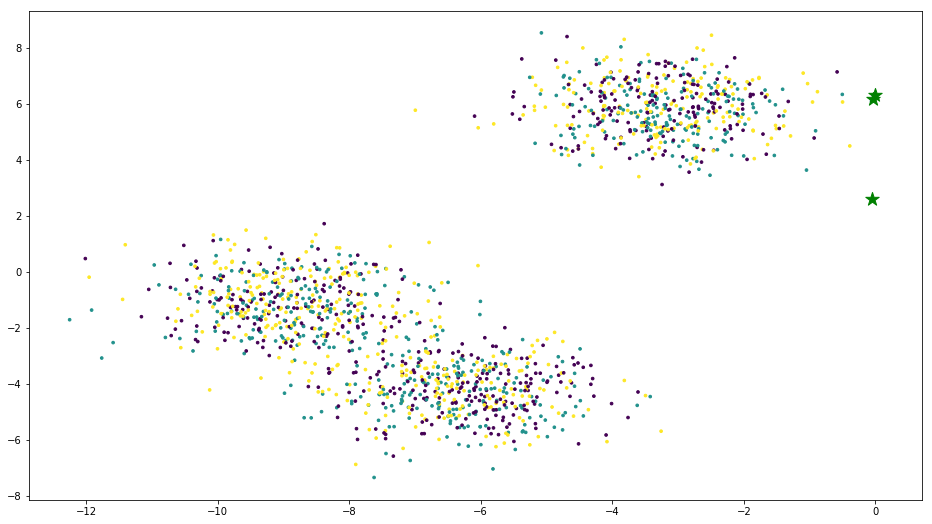

In [13]:
plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()

# Plotting along with the Centroids
#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata])
plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c=[actdata.label for actdata in mydata], s=7)

plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [14]:
len([actdata.label for actdata in mydata])

1600

In [15]:
# To store the value of centroids when it updates
C_old = np.zeros(C.shape)
# Error func. - Distance between new centroids and old centroids
error = dist(C, C_old, None)
print(error)

9.20352216626


In [16]:
print(C)
print(C.shape)

[[-0.01321891  6.31860393]
 [-0.05436939  2.59703834]
 [-0.02960836  6.16696433]]
(3, 2)


In [17]:
partials_Estep=[kmeans_tasks(task='estep', C=jsonpickle.encode(C), X=jsonpickle.encode(seq)) for seq in Xsubseqs]

*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***


 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***


*** we are in the E-Step ***
 *** Labels updated. E-step done ***


In [18]:
# the updated labels are here:
len(partials_Estep[0])

400

In [19]:
len(partials_Estep)

4

In [20]:
partials_Mstep=[kmeans_tasks(task='mstep', X=jsonpickle.encode(seq), n_clusters=n_clusters, n_features=n_features) for seq in partials_Estep]

*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***


In [21]:
partials_Mstep

[[array([ 6.0092659 , -3.48017712]),
  array([0., 0.]),
  array([-2.3358579 ,  0.07485583])],
 [array([ 5.89943126, -3.56189974]),
  array([0., 0.]),
  array([-2.53190349,  0.1812505 ])],
 [array([ 6.02136728, -3.75801813]),
  array([-2.9069365 ,  5.17256833]),
  array([-2.03460215, -0.02749127])],
 [array([ 6.01244687, -3.72604413]),
  array([0., 0.]),
  array([-2.61738411,  0.29236754])]]

In [22]:
C=np.sum(partials_Mstep,0)/n_workers
print(C)

[[ 5.98562783 -3.63153478]
 [-0.72673413  1.29314208]
 [-2.37993691  0.13024565]]


In [23]:
# Storing the old centroid values
C_old = deepcopy(C)
 

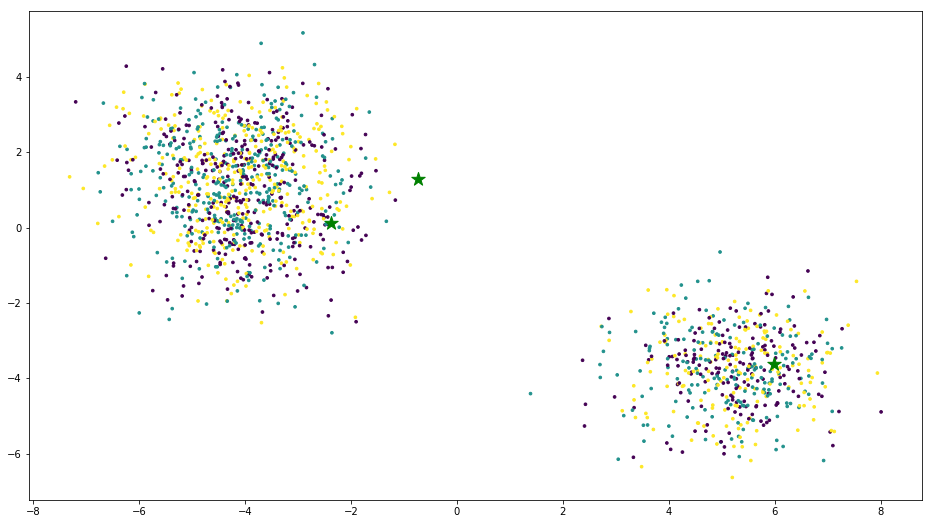

In [24]:
# Plotting along with the Centroids

#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c='#050505', s=7)
plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c=[actdata.label for actdata in mydata], s=7)
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


### Everything together

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


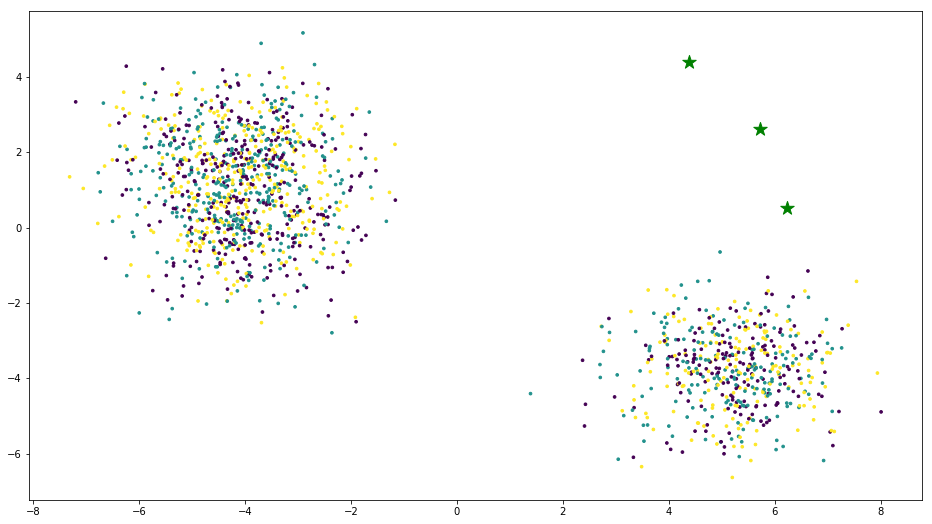

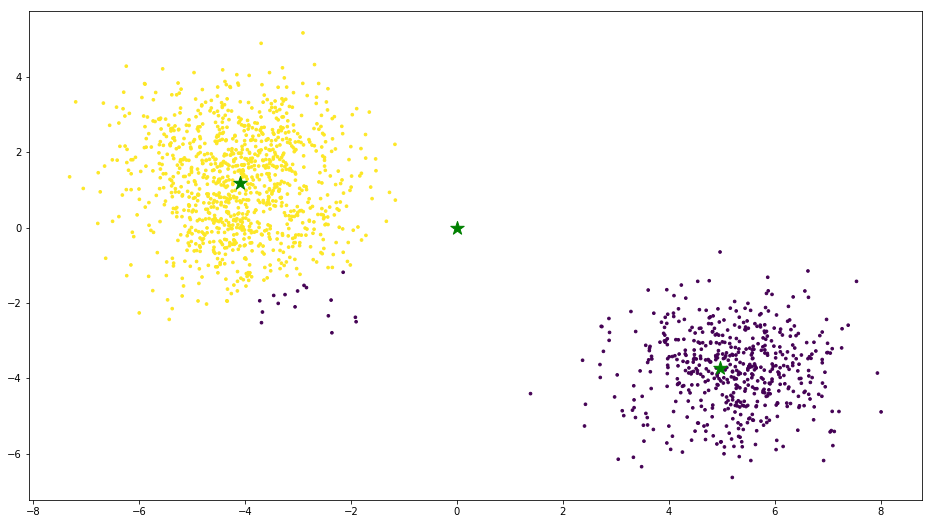

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


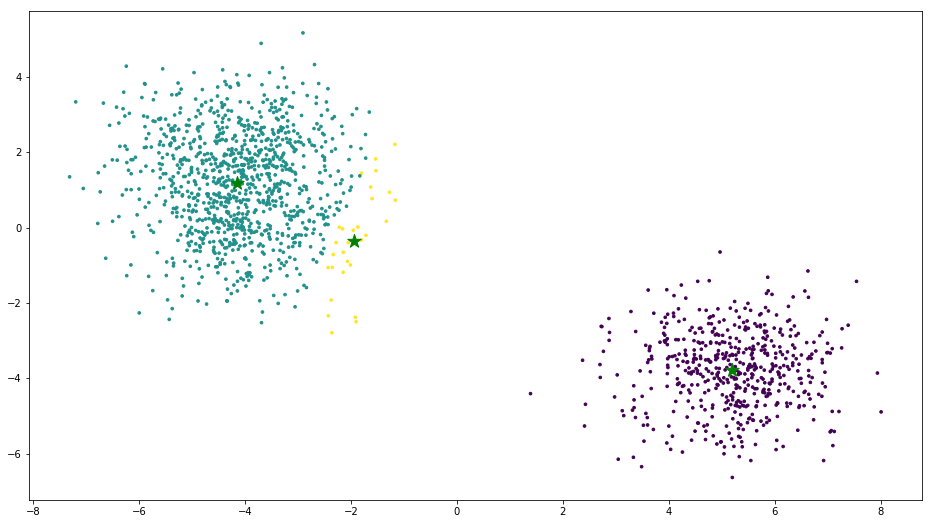

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


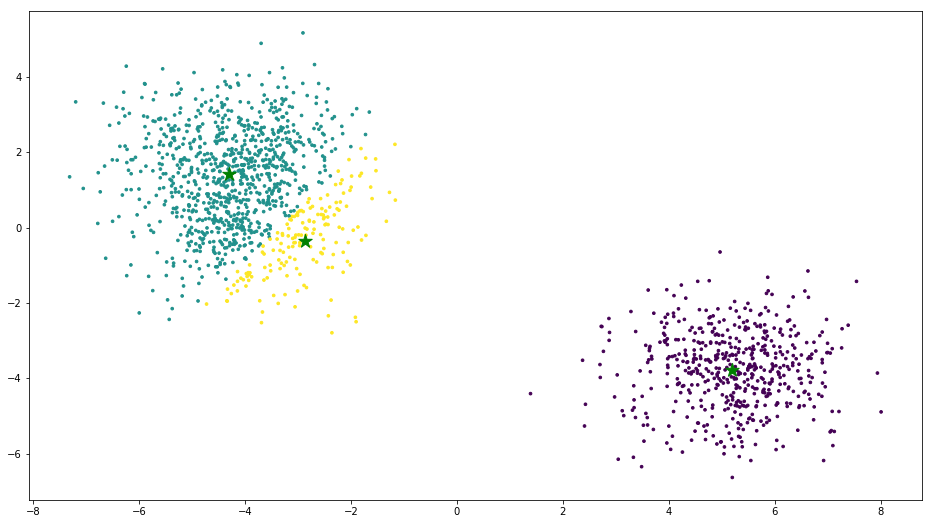

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


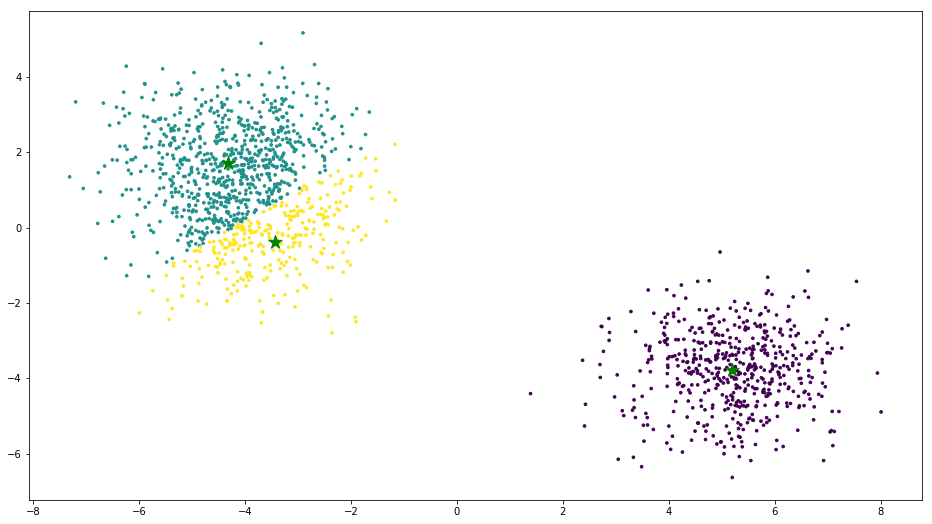

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


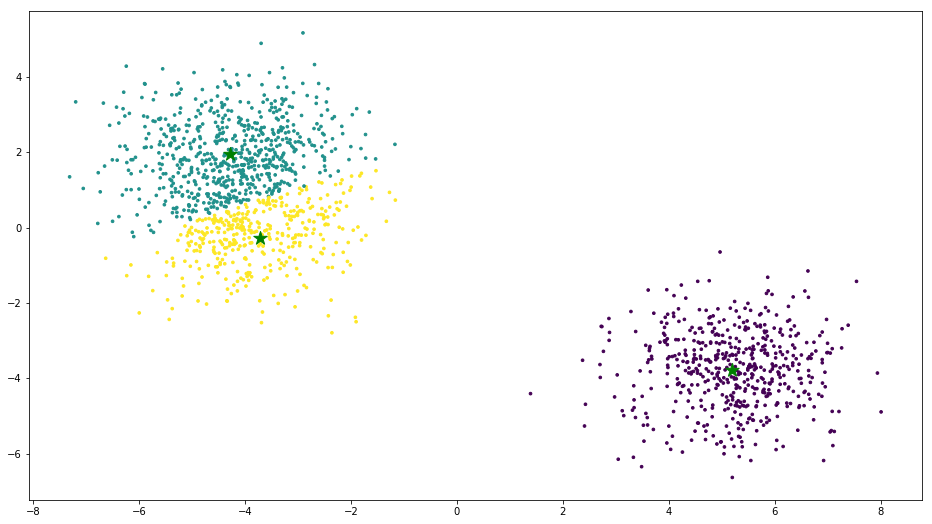

In [25]:
# Split the sequence in a number of chunks and process those independently.
n_workers = 4
n_iter =5

l = n_samples // n_workers
Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
Xsubseqs.append(mydata[(n_workers - 1) * l:])
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))

#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c='#050505', s=7)
plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c=[actdata.label for actdata in mydata], s=7)
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')

for iter in range(0, n_iter):    

    print(C.shape)
    
    #class assignnment
    partials_Estep=[kmeans_tasks(task='estep', C=jsonpickle.encode(C), X=jsonpickle.encode(seq)) for seq in Xsubseqs]
    
    #centroid update assignnment
    partials_Mstep=[kmeans_tasks(task='mstep', X=jsonpickle.encode(seq), n_clusters=n_clusters, n_features=n_features) for seq in partials_Estep]
    C=np.sum(partials_Mstep,0)/n_workers
    C_old = deepcopy(C)
    error = dist(C, C_old, None)
    print(error)

    Xsubseqs=deepcopy(partials_Estep)
    
    mydata_updated=[]
    for seq in partials_Estep:
        mydata_updated.extend(seq)
        print(len(seq))
    len(mydata_updated)

    plt.rcParams['figure.figsize'] = (16, 9)
    fig = plt.figure()
    plt.scatter([actdata.points[0] for actdata in mydata_updated], [actdata.points[1] for actdata in mydata_updated],c=[actdata.label for actdata in mydata_updated], s=7)
    plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')
    plt.show()
    
    #time.sleep(2)


### Distributed Kmeans

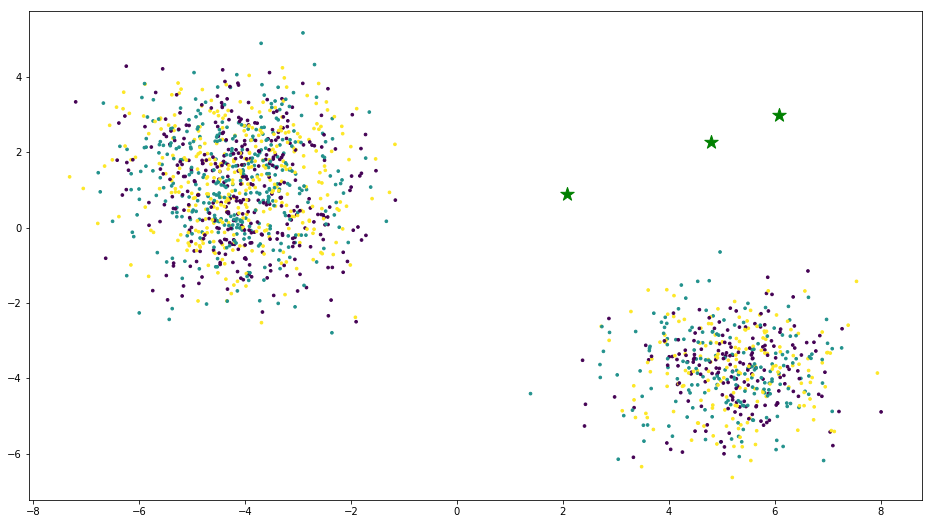

In [26]:
# Split the sequence in a number of chunks and process those independently.
n_workers = 4
n_iter =5

l = n_samples // n_workers
Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
Xsubseqs.append(mydata[(n_workers - 1) * l:])
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))

#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c='#050505', s=7)
plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c=[actdata.label for actdata in mydata], s=7)
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [27]:
for iter in range(0, n_iter):    

    print(C.shape)
    
    
    #class assignnment
    lazy_partials_Estep = group(kmeans_tasks.s(task='estep', C=jsonpickle.encode(C), X=jsonpickle.encode(seq)) for seq in Xsubseqs)() # call remote workers to run the sort task 
    partials_Estep = lazy_partials_Estep.get() # will wait for the tasks to return
    #partials_Estep=[kmeans_tasks(task='estep', C=C, X=seq) for seq in Xsubseqs]
    
    #centroid update assignnment
    lazy_partials_Mstep = group(kmeans_tasks.s(task='mstep', X=jsonpickle.encode(seq), n_clusters=n_clusters, n_features=n_features) for seq in partials_Estep)()
    partials_Mstep = lazy_partials_Mstep.get()
    #partials_Mstep=[kmeans_tasks(task='mstep', X=seq, n_clusters=n_clusters, n_features=n_features) for seq in partials_Estep]
    
    
    C=np.sum(partials_Mstep,0)/n_workers
    C_old = deepcopy(C)
    error = dist(C, C_old, None)
    print(error)

    Xsubseqs=deepcopy(partials_Estep)
    
    # for plotting the results
    mydata_updated=[]
    for seq in partials_Estep:
        mydata_updated.extend(seq)
        print(len(seq))
    len(mydata_updated)

    plt.rcParams['figure.figsize'] = (16, 9)
    fig = plt.figure()
    plt.scatter([actdata.points[0] for actdata in mydata_updated], [actdata.points[1] for actdata in mydata_updated],c=[actdata.label for actdata in mydata_updated], s=7)
    plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')
    plt.show()
    
    #time.sleep(2)




(3, 2)


AttributeError: 'dict' object has no attribute 'points'

In [29]:
import json

In [30]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


In [31]:
json_dump = json.dumps({'C': C, 'bb': [2]}, cls=NumpyEncoder)
print(json_dump)

{"C": [[0.7667001598513349, 8.634518785836606], [0.15759854456058559, 12.050005839387653], [0.8978595734664161, 3.0696139126770356]], "bb": [2]}


In [32]:
json_load = json.loads(json_dump)

C_restored = np.asarray(json_load["C"])
print(C_restored)
print(C_restored.shape)


[[ 0.76670016  8.63451879]
 [ 0.15759854 12.05000584]
 [ 0.89785957  3.06961391]]
(3, 2)


In [33]:
json_dump = json.dumps({'C': C, 'bb': [2], 'mydata': mydata}, cls=NumpyEncoder)

TypeError: Object of type 'PointsLabels' is not JSON serializable

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [43]:
decoded[0].label

1